GMU Simluation
==============

This python notebook simulates the GMU oracle given 12 months of bitcoin's price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

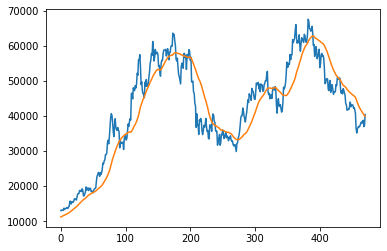

In [2]:
# fetch the last few prices of bitcoin
bitcoinPrice = pd.read_csv('bitcoin_price.csv')

plt.plot(bitcoinPrice['close'])
plt.plot(bitcoinPrice['sma_30'])

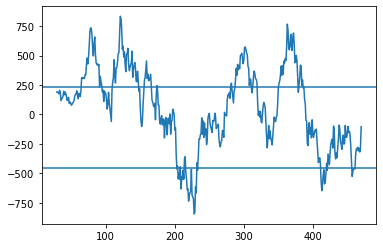

In [3]:
# calculate the slope of each pt/day
dailyPriceDelta = [0]
for i in range(len(bitcoinPrice.index)):
  if i!= 0:
    diff = (bitcoinPrice.loc[i,'close'] - bitcoinPrice.loc[i - 1,'close'])
    dailyPriceDelta.append(diff)

bitcoinPrice['slope'] = dailyPriceDelta

plt.plot(bitcoinPrice['slope'].rolling(30).mean())
plt.axhline(y = 230)
plt.axhline(y = -450)

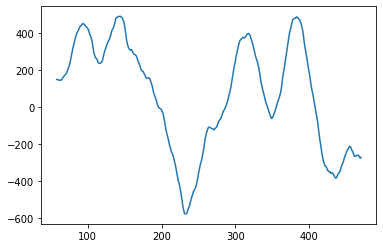

In [4]:
# putting rolling mean value of the slope
# do note in the slope, the index is taken to be an integer
bitcoinPrice['mean_slope'] = bitcoinPrice['slope'].rolling(30).mean()
bitcoinPrice.dropna(inplace = True)

plt.plot(bitcoinPrice['mean_slope'])

## Making the Indicator

I have made an indicator with the 30 day rolling mean value of the slope

```
slope = (
  (change in the consecutive values) /            
  (change in number of days = x - (x-1))
)
```

Can change 30 to any other thing. this makes it a laging indicator.

Details of the treshold, and the inequality:
in the start if its in between lower_T and upper_T, it is in an ambiguity, which i have labelled as start_ambiguity
but once if it reaches any extreme

lets say if it crosses upper_T, then it will attain the value of the close price at the exact index it crosses the upper_T, and 
    {unless and until the 30 day rolling mean value of the slope crosses, 
    lower_T (the other extreme)}
    
    this implies it will remain in downtrend

its current value will be determined by the:
    
    past value + (1*(current rolling mean value of the slope))
    
    when it crosses the lower_T,it will attain the constant value that it
    had during the uptrend, and now it is said to be in a downtrend
    
    it will remain so, unless it crosses the other extreme

In [9]:
slopeOutput = []
lower_T = -450
upper_T = 230
ptn = 0

meanSlope = np.array(bitcoinPrice['mean_slope'])

# Ptn will help us attain the memory part of thresholds
# assuming we start in the middle region
for i in range(len(meanSlope)):
  if ptn == 0:
    if meanSlope[i] <= lower_T:
      ptn = -1
      # c.append(['downtrend',i])
      # it will append the same, when it goes to the bottom if conditions
    elif meanSlope[i] >= upper_T:
      ptn = 1
    else: slopeOutput.append('start_ambiguity')
  if ptn == 1:
    if meanSlope[i] <= lower_T:
      ptn = -1
      # c.append(['downtrend',i])
    else: slopeOutput.append('uptrend')
  if ptn == -1:
    if meanSlope[i] >= upper_T:
      ptn = 1
      slopeOutput.append('uptrend')
    else: slopeOutput.append('downtrend')

bitcoinPrice['trend'] = slopeOutput
bitcoinPrice

,date,open,high,low,close,volume,sma_30,slope,mean_slope,trend
29,2020-11-20,17802.81,18815.22,17740.04,18655.67,88423.018489,14976.429667,852.85,189.571667,start_ambiguity
30,2020-11-21,18655.66,18965.90,18308.58,18703.80,75577.458394,15167.605667,48.13,191.176000,start_ambiguity
31,2020-11-22,18703.80,18750.00,17610.86,18414.43,81645.737778,15350.651000,-289.37,183.045333,start_ambiguity
32,2020-11-23,18413.88,18766.00,18000.00,18368.00,82961.506093,15525.860000,-46.43,175.209000,start_ambiguity
33,2020-11-24,18368.01,19418.97,18018.00,19160.01,113581.509241,15730.232667,792.01,204.372667,start_ambiguity
...,...,...,...,...,...,...,...,...,...,...
466,2022-01-31,37881.75,38744.00,36632.61,38466.90,36855.245800,40863.838000,585.14,-308.525000,downtrend
467,2022-02-01,38466.90,39265.20,38000.00,38694.59,34574.446630,40577.451667,227.69,-286.386333,downtrend
468,2022-02-02,38694.59,38855.92,36586.95,36896.36,35794.681300,40259.127000,-1798.23,-318.324667,downtrend
469,2022-02-03,36896.37,37387.00,36250.00,37311.61,32081.109990,39975.113667,415.25,-284.013333,downtrend


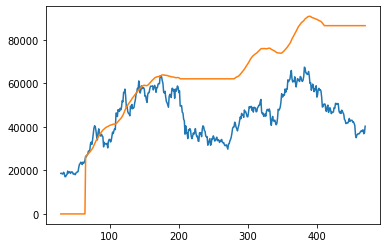

In [12]:
# based on direction of the trend we decide if we want to appreciate the peg or remain the same
indicator = []
for i in bitcoinPrice.index:
  if bitcoinPrice['trend'][i] == 'start_ambiguity':
    indicator.append(0)
  elif bitcoinPrice['trend'][i] == 'uptrend':
    idx = (len(indicator) - 1)
    if indicator[idx] == 0:
      indicator.append(bitcoinPrice['close'][i])
    else:
      indicator.append(indicator[idx] + ((bitcoinPrice['mean_slope'][i])*(1)))
  elif bitcoinPrice['trend'][i] == 'downtrend':
    idx = (len(indicator) - 1)
    if indicator[idx] == 0:
      indicator.append(bitcoinPrice['close'])
    else:
      indicator.append(indicator[idx])

bitcoinPrice['indicator'] = indicator

# plot the final graph
plt.plot(bitcoinPrice['close'])
plt.plot(bitcoinPrice['indicator'])